# Preamble

In [109]:
from my_units import *

In [110]:
import numpy as np
import pandas as pd
import scipy as sp

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad, nquad

import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

plt.rcdefaults()
fontsize = 14
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

from tqdm import tqdm, tqdm_notebook
from time import time as tictoc

# Solar Model

## Load data

B16: A new Generation of Standard Solar Models
arxiv:1611.09867

Structure and detailed composition of the AGSS09met model
Mass, radius and luminosity are normalized
T, rho, P in cgs
Abundances in mass fraction

In [111]:
df_solar = pd.read_csv('../data/solar_model/struct_b16_agss09.dat',skiprows=8,delim_whitespace=True)
df_solar

,Mass,Radius,Temp,Rho,Pres,Lumi,H1,He4,He3,C12,...,K,Ca,Sc,Ti,V,Cr,Mn,Fe,Co,Ni
0,1.000000e-07,0.0005,15440000.0,1.489000e+02,2.299000e+17,0.00000,0.36230,0.62176,0.000009,0.000008,...,0.000004,0.000067,4.309000e-08,0.000003,3.969000e-07,0.000019,0.000014,0.001344,0.000004,0.000079
1,2.000000e-07,0.0010,15440000.0,1.489000e+02,2.299000e+17,0.00000,0.36232,0.62174,0.000009,0.000008,...,0.000004,0.000067,4.306000e-08,0.000003,3.966000e-07,0.000019,0.000014,0.001344,0.000004,0.000079
2,4.000000e-07,0.0015,15440000.0,1.489000e+02,2.299000e+17,0.00000,0.36235,0.62171,0.000009,0.000008,...,0.000004,0.000067,4.308000e-08,0.000003,3.968000e-07,0.000019,0.000014,0.001344,0.000004,0.000079
3,8.000000e-07,0.0020,15440000.0,1.489000e+02,2.299000e+17,0.00001,0.36239,0.62166,0.000009,0.000008,...,0.000004,0.000067,4.311000e-08,0.000003,3.971000e-07,0.000019,0.000014,0.001345,0.000004,0.000080
4,1.700000e-06,0.0025,15440000.0,1.488000e+02,2.299000e+17,0.00001,0.36245,0.62160,0.000009,0.000008,...,0.000004,0.000067,4.313000e-08,0.000003,3.972000e-07,0.000019,0.000014,0.001346,0.000004,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.000000e+00,0.9980,15840.0,3.895000e-06,5.309000e+06,0.99891,0.75488,0.23164,0.000033,0.002366,...,0.000004,0.000060,3.895000e-08,0.000003,3.588000e-07,0.000018,0.000013,0.001216,0.000003,0.000072
1996,1.000000e+00,0.9985,14390.0,2.113000e-06,2.501000e+06,0.99891,0.75488,0.23164,0.000033,0.002366,...,0.000004,0.000060,3.895000e-08,0.000003,3.588000e-07,0.000018,0.000013,0.001216,0.000003,0.000072
1997,1.000000e+00,0.9990,12830.0,1.043000e-06,1.040000e+06,0.99891,0.75488,0.23164,0.000033,0.002366,...,0.000004,0.000060,3.895000e-08,0.000003,3.588000e-07,0.000018,0.000013,0.001216,0.000003,0.000072
1998,1.000000e+00,0.9995,10830.0,4.554000e-07,3.548000e+05,0.99891,0.75488,0.23164,0.000033,0.002366,...,0.000004,0.000060,3.895000e-08,0.000003,3.588000e-07,0.000018,0.000013,0.001216,0.000003,0.000072


## Temperature 'temp_solar'

In [112]:
int_temp_solar = interp1d(np.log10(df_solar['Radius']),np.log10(df_solar['Temp']*Kelvin),
                          bounds_error=False,fill_value=(np.min(np.log10(df_solar['Temp']*Kelvin)),-40))

def temp_solar(R):
    """Returns Solar temperature as a function of radius (R)."""
    return 10**int_temp_solar(np.log10(R/RSolar))

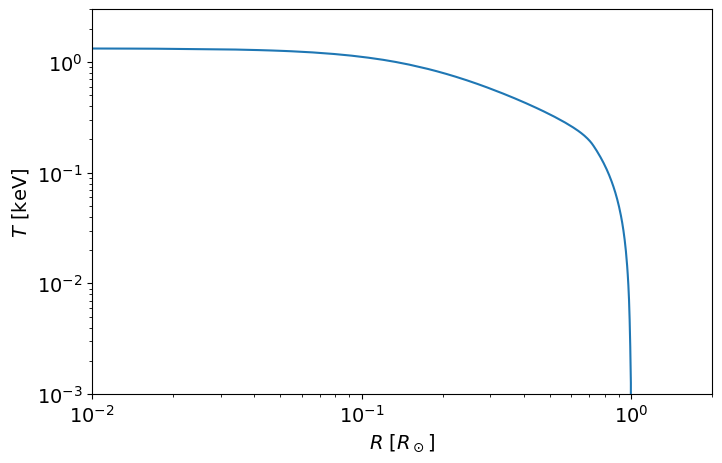

In [113]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_R = np.logspace(-2,np.log10(2),1000) * RSolar
ax.plot(vec_R/RSolar,temp_solar(vec_R)/keV)
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(vec_R[0]/RSolar,vec_R[-1]/RSolar); ax.set_ylim(10**-3,3);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel('$T ~[\mathrm{keV}]$');

## Number Densities 'ne_solar' and 'nbar_solar'

In [114]:
int_ne_solar = interp1d(np.log10(df_solar['Radius']),
                        np.log10(Gram*CentiMeter**(-3)/MProton * df_solar['Rho'] * (
                            1*df_solar['H1']+(2/4)*df_solar['He4']+(2/3)*df_solar['He3']+(6/12)*df_solar['C12']+(6/13)*df_solar['C13']
                            +(7/14)*df_solar['N14']+(7/15)*df_solar['N15']+(8/16)*df_solar['O16']+(8/17)*df_solar['O17']+(8/18)*df_solar['O18']
                            +(10/20.2)*df_solar['Ne']+(11/23.0)*df_solar['Na']+(12/24.3)*df_solar['Mg']
                            +(13/27.0)*df_solar['Al']+(14/28.1)*df_solar['Si']
                            +(15/30.0)*df_solar['P']+(16/32.1)*df_solar['S']+(17/35.5)*df_solar['Cl']+(18/39.9)*df_solar['Ar']
                            +(19/39.1)*df_solar['K']+(20/40.1)*df_solar['Ca']+(21/45.0)*df_solar['Sc']+(22/47.9)*df_solar['Ti']
                            +(23/50.9)*df_solar['V']+(24/52.0)*df_solar['Cr']+(25/54.9)*df_solar['Mn']+(26/55.8)*df_solar['Fe']
                            +(27/58.9)*df_solar['Co']+(28/58.7)*df_solar['Ni']
                        )),
                        bounds_error=False,fill_value=(np.min(np.log10(df_solar['Temp']*Kelvin)),-40))

def ne_solar(R):
    """Returns Solar electron number density as a function of radius (R)."""
    return 10**int_ne_solar(np.log10(R/RSolar))

int_nbar_solar = interp1d(np.log10(df_solar['Radius']),
                        np.log10(Gram*CentiMeter**(-3)/MProton * df_solar['Rho'] * (
                            1*df_solar['H1']+(2**2/4)*df_solar['He4']+(2**2/3)*df_solar['He3']+(6**2/12)*df_solar['C12']+(6**2/13)*df_solar['C13']
                            +(7**2/14)*df_solar['N14']+(7**2/15)*df_solar['N15']+(8**2/16)*df_solar['O16']+(8**2/17)*df_solar['O17']+(8**2/18)*df_solar['O18']
                            +(10**2/20.2)*df_solar['Ne']+(11**2/23.0)*df_solar['Na']+(12**2/24.3)*df_solar['Mg']
                            +(13**2/27.0)*df_solar['Al']+(14**2/28.1)*df_solar['Si']
                            +(15**2/30.0)*df_solar['P']+(16**2/32.1)*df_solar['S']+(17**2/35.5)*df_solar['Cl']+(18**2/39.9)*df_solar['Ar']
                            +(19**2/39.1)*df_solar['K']+(20**2/40.1)*df_solar['Ca']+(21**2/45.0)*df_solar['Sc']+(22**2/47.9)*df_solar['Ti']
                            +(23**2/50.9)*df_solar['V']+(24**2/52.0)*df_solar['Cr']+(25**2/54.9)*df_solar['Mn']+(26**2/55.8)*df_solar['Fe']
                            +(27**2/58.9)*df_solar['Co']+(28**2/58.7)*df_solar['Ni']
                        )),
                        bounds_error=False,fill_value=(np.min(np.log10(df_solar['Temp']*Kelvin)),-40))

def nbar_solar(R):
    """Returns Solar electron number density as a function of radius (R)."""
    return 10**int_nbar_solar(np.log10(R/RSolar))

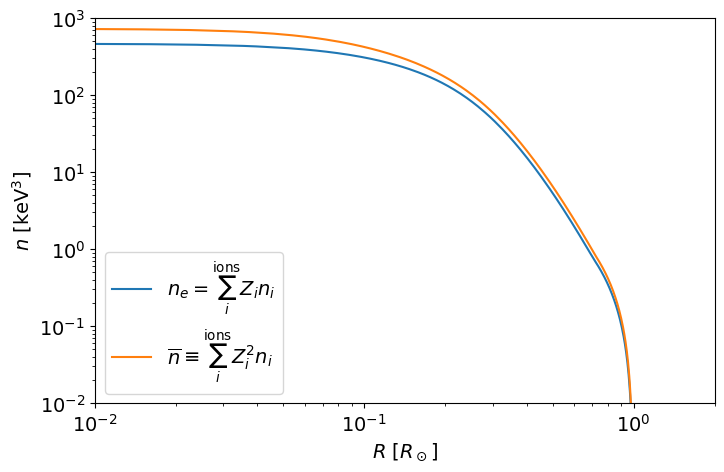

In [115]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_R = np.logspace(-2,np.log10(2),1000) * RSolar
ax.plot(vec_R/RSolar,ne_solar(vec_R)/keV**3,label=r'$n_e = \sum_i^\mathrm{ions} Z_i n_i$')
ax.plot(vec_R/RSolar,nbar_solar(vec_R)/keV**3,label=r'$\overline{n} \equiv \sum_i^\mathrm{ions} Z_i^2 n_i$')
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(vec_R[0]/RSolar,vec_R[-1]/RSolar); ax.set_ylim(10**-2,10**3);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel('$n ~[\mathrm{keV^3}]$');
ax.legend(loc = 'lower left');

## Plasma Frequency 'omega_pl_solar' and Radius where $\omega_\mathrm{pl} = m$ 'radius_res_solar'

In [205]:
def omega_pl_solar(R):
    """Plasma frequency as a function of solar radius 'R'."""
    return np.sqrt(4 * np.pi * AlphaEM * ne_solar(R) / MElectron)

In [206]:
vec_R = np.logspace(-4,0,int(1e7)) * RSolar
vec_omega_pl = omega_pl_solar(vec_R)
radius_res_solar = interp1d(vec_omega_pl,vec_R,bounds_error=False,fill_value=(1e-4*RSolar,1*RSolar))

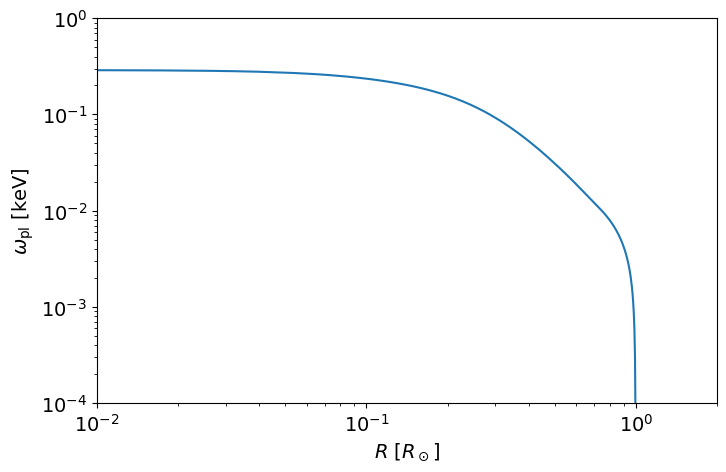

In [207]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_R = np.logspace(-2,np.log10(2),1000) * RSolar
ax.plot(vec_R/RSolar,omega_pl_solar(vec_R)/keV)
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(vec_R[0]/RSolar,vec_R[-1]/RSolar); ax.set_ylim(10**-4,1);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel('$\omega_\mathrm{pl} ~[\mathrm{keV}]$');

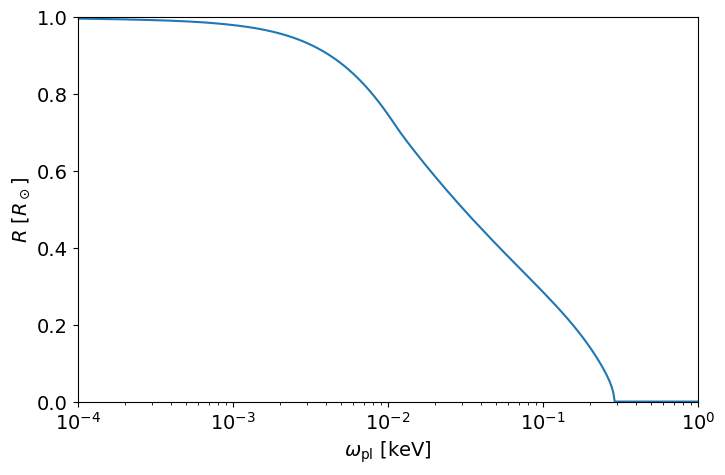

In [208]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_omega_pl = np.logspace(-4,0,1000) * keV
ax.plot(vec_omega_pl/keV,radius_res_solar(vec_omega_pl)/RSolar)
ax.set_xscale('log'); ax.set_yscale('linear');
ax.set_xlim(1e-4,1); ax.set_ylim(0,1);
ax.set_ylabel(r'$R ~[R_\odot]$'); ax.set_xlabel('$\omega_\mathrm{pl} ~[\mathrm{keV}]$');

## Debye-Huckel scale 'kappa_solar'

In [559]:
def kappa_solar(R):
    """Debye-Huckel scale as a function of solar radius 'R'."""
    return np.sqrt(4 * np.pi * AlphaEM * (ne_solar(R) + nbar_solar(R)) / temp_solar(R))

## Enclosed Mass 'm_solar' and Gravitational Potential 'Phi_solar'

In [120]:
int_m_solar = interp1d(np.log10(df_solar['Radius']),np.log10(df_solar['Mass']),
                          bounds_error=False,fill_value=(np.min(np.log10(df_solar['Mass'])),0))

def m_solar(R):
    """Returns enclosed solar mass as a function of radius (R)."""
    return MSolar * 10**int_m_solar(np.log10(R/RSolar))

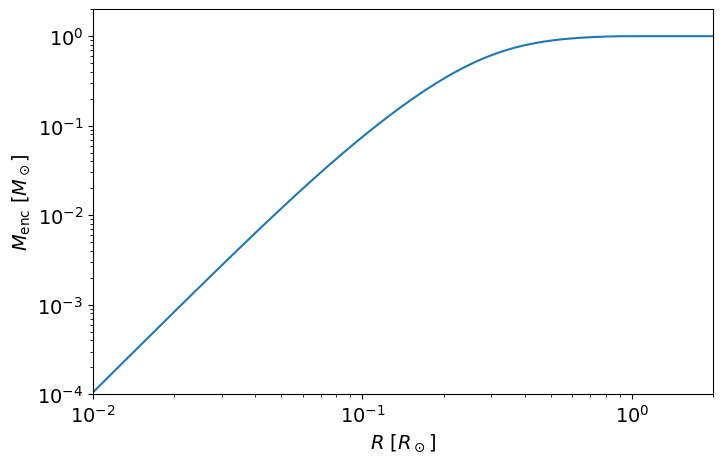

In [121]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_R = np.logspace(-2,np.log10(2),1000) * RSolar
ax.plot(vec_R/RSolar,m_solar(vec_R)/MSolar)
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(vec_R[0]/RSolar,vec_R[-1]/RSolar); ax.set_ylim(10**-4,2);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel('$M_\mathrm{enc} ~[M_\odot]$');

In [122]:
vec_R = np.logspace(-3,0,int(1e4)) * RSolar
vec_m_enc = m_solar(vec_R)/MSolar/(vec_R/RSolar)**2
vec_Phi_differential = vec_m_enc[0:-1] * (vec_R[1:]-vec_R[0:-1])/RSolar
vec_Phi_interior = np.asarray([np.sum(vec_Phi_differential[-i-1:-1]) for i in range(len(vec_R)-1,0,-1) ])
int_Phi_interior = interp1d(vec_R[0:-1]/RSolar,vec_Phi_interior,bounds_error=False,fill_value=(vec_Phi_interior[0],0))

def Phi_solar(R):
    """Returns solar gravitational potential Phi(R). Equals -GN MSolar / R for R > RSolar."""
    x = R/RSolar
    try:
        fac = ([x<1] * (1+int_Phi_interior(x)) + [x >=1 ] * 1/x)[0]
    except TypeError:
        if x < 1:
            fac = (1+int_Phi_interior(x))
        else:
            fac = 1/x
    return -GN * MSolar / RSolar * fac

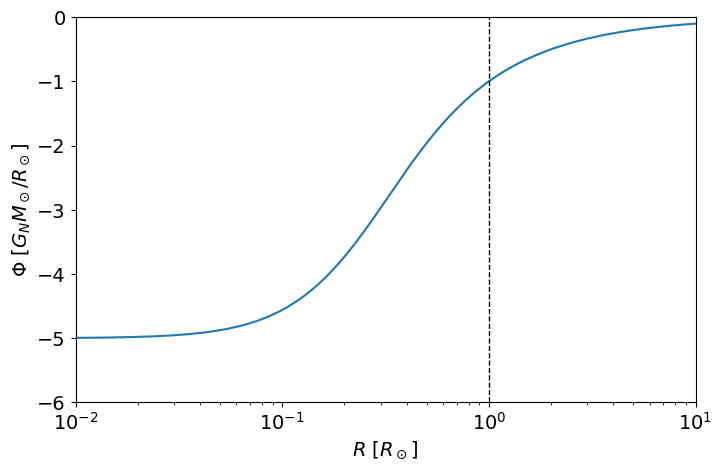

In [123]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_R = np.logspace(-2,1,1000) * RSolar
ax.plot(vec_R/RSolar,Phi_solar(vec_R)/(GN * MSolar / RSolar))
ax.set_xscale('log'); ax.set_yscale('linear');
ax.set_xlim(vec_R[0]/RSolar,vec_R[-1]/RSolar); ax.set_ylim(-6,0);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel('$\Phi ~[G_N M_\odot/R_\odot]$');
ax.axvline(1,color='black',ls='dashed',lw=1);

## Escape Velocity 'v_esc_solar'

In [124]:
def v_esc_solar(R):
    """Returns solar escape velocity"""
    return np.sqrt(-2*Phi_solar(R))

# Solar Basin Simulations

## Solar Hits from Backward Simulations

In [ ]:
df_backward = pd.read_csv('../data/forward_sims/hit_record.csv',header=None,names=['t','d','xe_x','xe_y','xe_z','ve_x','ve_y','ve_z','vp_x','vp_y','vp_z'])

## Earth Hits from Forward Simulations

In [125]:
df_forward = pd.read_csv('../data/forward_sims/hit_record.csv',header=None,names=['t','d','xe_x','xe_y','xe_z','ve_x','ve_y','ve_z','vp_x','vp_y','vp_z'])

In [126]:
df_forward

,t,d,xe_x,xe_y,xe_z,ve_x,ve_y,ve_z,vp_x,vp_y,vp_z
0,1856.996926,0.048425,0.639982,0.762952,0.040987,-0.763445,0.658376,0.013403,0.297874,-0.585933,-0.544938
1,2787.997006,0.047260,0.637039,0.765369,0.041294,-0.765896,0.655559,0.013002,0.301630,-0.582876,-0.546000
2,3253.499583,0.046329,0.633210,0.768537,0.041484,-0.769066,0.651846,0.012675,0.303283,-0.581700,-0.546613
3,3827.379484,0.045850,0.649703,0.754167,0.041359,-0.755046,0.668561,0.013427,0.284664,-0.604966,-0.549383
4,4292.878529,0.046485,0.649789,0.754081,0.041485,-0.754933,0.668707,0.013312,0.290240,-0.599298,-0.549644
...,...,...,...,...,...,...,...,...,...,...,...
1253322,116.744586,0.039962,0.549601,-0.865277,0.003767,0.820939,0.535679,-0.003128,-0.191850,0.257739,0.051396
1253323,2482.593308,0.032888,0.629852,-0.807422,0.003942,0.765610,0.613740,-0.004134,0.255530,-0.385849,0.066056
1253324,3375.349581,0.036695,0.642020,-0.797593,0.004054,0.756213,0.625509,-0.004451,-0.210143,0.219813,0.059055
1253325,3681.456976,0.029621,0.665486,-0.777610,0.003973,0.737046,0.648550,-0.004659,0.241726,-0.331085,0.053780


# Axion

## Production

### Bound Energy Loss Rate Function 'Q_tilde_axion'

In [537]:
def Q_tilde_axion_brem(m,R,gaee):
    """Bound energy loss rate function \tilde{Q} from bremsstrahlung as a function of axion mass 'm', radius 'R', and axion-electron coupling 'gaee'."""
    temp = temp_solar(R)
    nbar = nbar_solar(R)
    ne = ne_solar(R)
    prefac = gaee**2 * AlphaEM**2 / (2 * np.pi**(3/2)) * (nbar * ne/np.sqrt(2)) * m**3 / MElectron**4 * (MElectron/temp)**(1/2)
    m_dependence = 4.7 * np.exp(-1.38 * np.sqrt(m/temp) - 0.704 * m/temp - 0.024 * (m/temp)**(3/2)) #empirical approximation to integral
    return prefac * m_dependence

In [551]:
def Q_tilde_axion_compton(m,R,gaee):
    """Bound energy loss rate function \tilde{Q} from Compton production (photoproduction) as a function of axion mass 'm', radius 'R', and axion-electron coupling 'gaee'."""
    temp = temp_solar(R)
    ne = ne_solar(R)
    omega_pl = omega_pl_solar(R)
    prefac = gaee**2 * AlphaEM / (2**(3/2) * np.pi**2) * ne / MElectron**4
    if m > omega_pl:
        m_dependence = m**6 / (np.exp(m/temp) - 1) * np.abs(np.sqrt(1-omega_pl**2/m**2)) 
    else:
        m_dependence = 1e-100
    return prefac * m_dependence

In [617]:
def Q_tilde_axion_electron(m,R,gaee):
    """Bound energy loss rate function \tilde{Q} as a function of axion mass 'm', radius 'R', and axion-electron coupling 'gaee'."""
    return Q_tilde_axion_brem(m,R,gaee) + Q_tilde_axion_compton(m,R,gaee)

In [615]:
def Q_tilde_axion_primakoff(m,R,gagg):
    """Bound energy loss rate function \tilde{Q} from Primakoff production as a function of axion mass 'm', radius 'R', and axion-photon coupling 'gagg'.
    NOTE: Does not yet include plasma frequency effects."""
    temp = temp_solar(R)
    ne = ne_solar(R)
    nbar = nbar_solar(R)
    omega_pl = omega_pl_solar(R)
    kappa = kappa_solar(R)
    return 1/(2*np.sqrt(2)*np.pi**3) * ElectronCharge**2 * gagg**2 * (ne * temp)/MElectron * m**4 / np.exp(m/temp) * m**2 / (m**2 + kappa**2) 

### Total Energy Loss Rate

In [541]:
def Q_axion_brem(m,R,gaee):
    """Unbound energy loss rate Q per unit volume from bremsstrahlung as a function of axion mass 'm', radius 'R', and axion-electron coupling 'gaee'.
    NOTE: mass dependence not yet implemented."""
    temp = temp_solar(R)
    nbar = nbar_solar(R)
    ne = ne_solar(R)
    return np.sqrt(2/np.pi) * (128/45) * AlphaEM**2 * gaee**2/(4*np.pi) * (nbar * ne/np.sqrt(2)) * ne / MElectron * (temp/MElectron)**(5/2)

In [542]:
def Q_axion_compton(m,R,gaee):
    """Unbound energy loss rate Q per unit volume from Compton production (photoproduction) as a function of axion mass 'm', radius 'R', and axion-electron coupling 'gaee'.
    NOTE: mass dependence not yet implemented."""
    temp = temp_solar(R)
    ne = ne_solar(R)
    return 8 / np.pi * gaee**2/(4*np.pi) * AlphaEM * ne * sp.special.zeta(6) / MElectron**2 * temp**4 * (20 * temp**2 / MElectron**2);

# Dark Photon

## Production

### Damping Rate 'Gamma_L_solar'

In [127]:
def Gamma_L_solar(omega,R):
    """Returns longitudinal damping rate as a function of frequency and solar radius."""
    temp = temp_solar(R); ne = ne_solar(R); nbar = nbar_solar(R); omega_pl = omega_pl_solar(R);
    fac_res = 64 * np.pi**2 * AlphaEM**3 * ne * nbar / (3 * np.sqrt(2*np.pi*temp) * MElectron**(3/2) * omega**3)
    y = omega/(2*temp)
    if y < 250:
        Gamma_L_res = fac_res * sp.special.kn(0,y) * np.sinh(y)
    else:
        Gamma_L_res = fac_res * sp.special.kn(0,250) * np.sinh(250) / np.sqrt(y/250)
    x = omega/omega_pl
    try:
        Gamma_L_offshell = ([x>1] * (8 * np.pi * AlphaEM**2 * ne) / (3 * MElectron**2) * np.real(np.sqrt(1-1/x**2)))[0]
    except TypeError:
        if x > 1:
            Gamma_L_offshell =  (8 * np.pi * AlphaEM**2 * ne) / (3 * MElectron**2) * np.sqrt(1-1/x**2)
        else:
            Gamma_L_offshell = 0
    return Gamma_L_res + Gamma_L_offshell
Gamma_L_solar = np.vectorize(Gamma_L_solar)

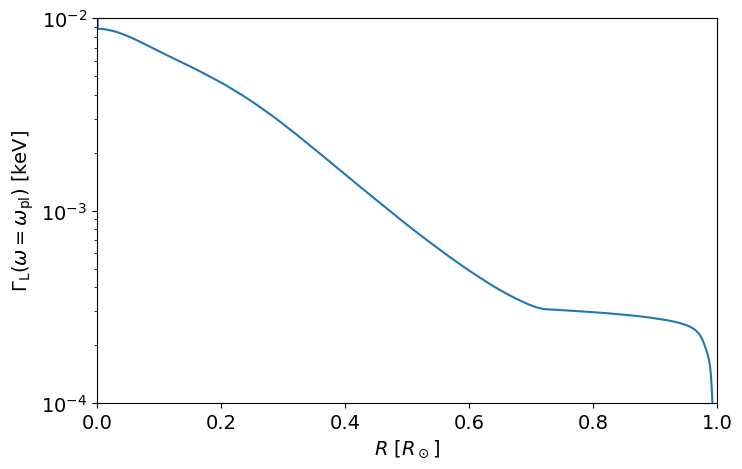

In [128]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
vec_R = np.linspace(1e-4,1,1000) * RSolar
ax.plot(vec_R/RSolar,Gamma_L_solar(omega_pl_solar(vec_R),vec_R)/keV)
ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(0*vec_R[0]/RSolar,vec_R[-1]/RSolar); ax.set_ylim(10**-4,10**-2);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel('$\Gamma_\mathrm{L}(\omega = \omega_\mathrm{pl}) ~[\mathrm{keV}]$');

### Bound Energy Loss Rate Function 'Q_tilde_DP'

In [129]:
def Q_tilde_DP_solar(m,R,epsilon):
    """Bound energy loss rate function \tilde{Q} as a function of dark photon mass 'm', radius 'R', and kinetic mixing 'epsilon'."""
    temp = temp_solar(R)
    Gamma_L = Gamma_L_solar(m,R)
    omega_pl = omega_pl_solar(R)
    return 3* epsilon**2 / (np.sqrt(2)*np.pi**2) * m**6 / (np.exp(m/temp)-1) * (m**2 * Gamma_L)/((m**2 - omega_pl**2)**2 + (m * Gamma_L)**2)

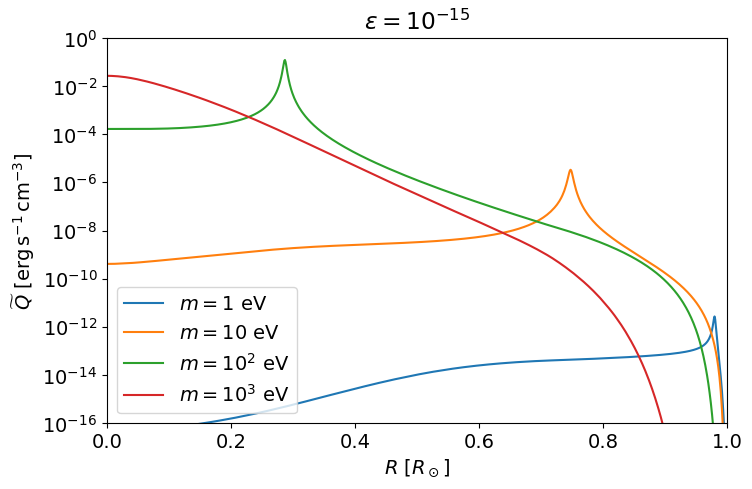

In [130]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
epsilon = 1e-15
vec_R = np.linspace(1e-3,0.997,int(1e3)) * RSolar
vec_m = np.asarray([1,10,100,1000]) * eV
for m in vec_m:
    ax.plot(vec_R/RSolar,Q_tilde_DP_solar(m,vec_R,epsilon)/(erg * Second**-1 * CentiMeter**-3))
ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(0,1); ax.set_ylim(1e-16,1e0);
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel(r'$\widetilde{Q} ~ [\mathrm{erg \, s^{-1} \, cm^{-3}}]$');
ax.legend(['$m = 1~\mathrm{eV}$','$m = 10~\mathrm{eV}$','$m = 10^2~\mathrm{eV}$','$m = 10^3~\mathrm{eV}$'],loc='lower left');
ax.set_title(r'$\epsilon = 10^{-15}$');

### Total Energy Loss Rate

In [209]:
def Q_integrand_DP_solar(omega,m,R,epsilon):
    """Integrand for energy loss rate Q for dark photons in the sun, which is the integral over omega of this function."""
    Gamma_L = Gamma_L_solar(omega,R); temp = temp_solar(R); omega_pl = omega_pl_solar(R);
    prefac = (1/(2*np.pi**2)) * omega**3 * np.sqrt((omega**2 - m**2)/omega**2) * (epsilon**2 * m**2) / (np.exp(omega/temp)-1) 
    lorentzian_L = omega**2 * Gamma_L / ((omega**2 - omega_pl**2)**2 + (omega * Gamma_L)**2)
    lorentzian_T = 2 * m**2 * Gamma_L / ((m**2 - omega_pl**2)**2 + (omega * Gamma_L)**2)
    return prefac * (lorentzian_L + lorentzian_T)

In [211]:
def Q_DP_solar(m,R,epsilon,epsrel=1e-6):
    """Energy loss rate Q for dark photons in the sun, as a function of mass 'm', solar radius 'R', and kinetic mixing 'epsilon'."""
    omega_max = 100 * temp_solar(R)
    omega_pl = omega_pl_solar(R)
    if m < omega_pl:
        points = np.asarray([0.9,0.99,0.999,0.9999,0.99999,1,1.00001,1.0001,1.001,1.01,1.1])*omega_pl
        points = points[points>m]
    else:
        points = []
    if m < omega_max:
        return quad(Q_integrand_DP_solar,a=m*(1+1e-10),b=omega_max,args=(m,R,epsilon),epsrel=epsrel,epsabs=0,full_output=0)[0]
    else:
        return 0.0

Q_DP_solar_vec = np.vectorize(Q_DP_solar_tmp)

In [618]:
df_Q_DP_solar = pd.read_csv('../results/Q_DP_solar.csv')

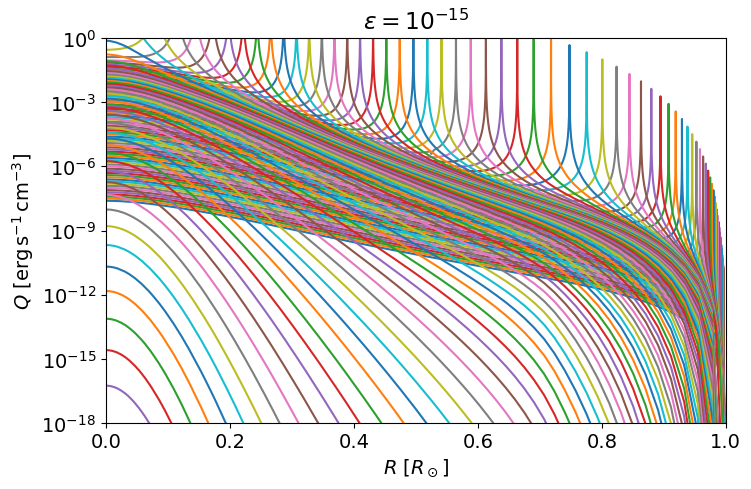

In [313]:
vec_m = eV * df_Q_DP_solar['m [eV]'].unique()

fig,ax = plt.subplots(1,1,figsize=(8,5))
epsilon = 1e-15
for i_m, m in enumerate(vec_m):
    idx = df_Q_DP_solar['m [eV]']==m/eV
    ax.plot(df_Q_DP_solar[idx]['radius [R_solar]'],epsilon**2 * df_Q_DP_solar[idx]['Q [erg/s/cm^3]'],label=str(m/eV)[0:6]+' eV')

ax.set_xscale('linear'); ax.set_yscale('log');
ax.set_xlim(0,1); ax.set_ylim(1e-18,1e0);
ax.set_title(r'$\epsilon = 10^{-15}$');
ax.set_xlabel(r'$R ~[R_\odot]$'); ax.set_ylabel(r'$Q ~ [\mathrm{erg \, s^{-1} \, cm^{-3}}]$');
#ax.legend(loc='lower left');

In [314]:
vec_m = eV * df_Q_DP_solar['m [eV]'].unique()
vec_Lum = np.zeros(len(vec_m))

for i_m, m in enumerate(vec_m):
    idx = df_Q_DP_solar['m [eV]']==m/eV
    
    vec_R = RSolar * df_Q_DP_solar[idx]['radius [R_solar]'].to_numpy()
    vec_Q = erg * Second**-1 * CentiMeter**-3 * df_Q_DP_solar[idx]['Q [erg/s/cm^3]'].to_numpy()
    
    for i_R in range(len(vec_R)-1):
        vec_Lum[i_m] += 4 * np.pi * vec_R[i_R]**2 * (vec_R[i_R+1] - vec_R[i_R]) * vec_Q[i_R]

In [315]:
vec_Lum / LumSolar

array([5.56596830e+19, 7.00713806e+19, 8.82146278e+19, 1.11055625e+20,
       1.39810736e+20, 1.76011225e+20, 2.21584928e+20, 2.78958807e+20,
       3.51188217e+20, 4.42119626e+20, 5.56595505e+20, 7.00712398e+20,
       8.82145021e+20, 1.11055666e+21, 1.39811069e+21, 1.76011939e+21,
       2.21587080e+21, 2.78965893e+21, 3.51208145e+21, 4.42169067e+21,
       5.56712643e+21, 7.00976229e+21, 8.82726502e+21, 1.11185667e+22,
       1.40102438e+22, 1.76674787e+22, 2.23075171e+22, 2.82324617e+22,
       3.58733370e+22, 4.58401778e+22, 5.93964274e+22, 7.82720832e+22,
       1.07022486e+23, 1.51018793e+23, 2.28627131e+23, 3.66559087e+23,
       6.15409678e+23, 1.10495796e+24, 2.10745336e+24, 4.38494418e+24,
       7.18652055e+24, 1.41382024e+25, 2.01675819e+25, 3.04545818e+25,
       4.21512279e+25, 5.71797286e+25, 8.05192283e+25, 1.07038938e+26,
       1.43120044e+26, 2.04056540e+26, 2.61617710e+26, 3.23828872e+26,
       4.42452818e+26, 5.64886435e+26, 7.60907206e+26, 1.02033002e+27,
      

In [361]:
int_Lum_DP_solar = interp1d(np.log10(vec_m),np.log10(vec_Lum),bounds_error=False,fill_value=1e-40*LumSolar)

In [362]:
def Lum_DP_solar(m,epsilon=1):
    """Luminosity of dark photons produced in the sun, as a function of mass 'm' and kinetic mixing 'epsilon'."""
    return epsilon**2 * 10**int_Lum_DP_solar(np.log10(m))

def rho_unbound_DP_solar(m,R=AU,epsilon=1):
    """Energy density of unbound dark photons produced in the sun, as a function of mass 'm', radius 'R', and kinetic mixing 'epsilon'."""
    return Lum_DP_solar(m,epsilon) / (4*np.pi*R**2)

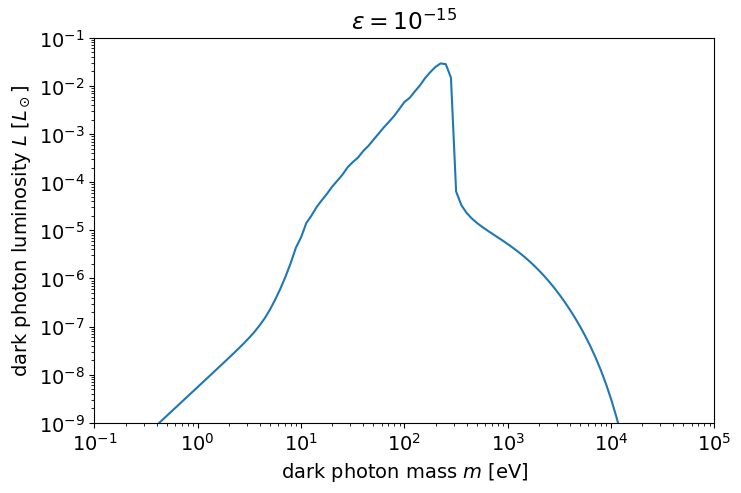

In [363]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlim(1e-1,1e5); ax.set_ylim(1e-9,1e-1);
ax.plot(vec_m/eV,Lum_DP_solar(vec_m,epsilon=1e-15)/LumSolar);
ax.set_title(r'$\epsilon = 10^{-15}$');
ax.set_xlabel(r'dark photon mass $m ~[\mathrm{eV}]$'); ax.set_ylabel(r'dark photon luminosity $L ~[L_\odot]$'); 

## Non-Basin Constraints

### Solar Cooling Constraint

In [390]:
def epsilon_solar_cooling(m,Lum_frac=0.1):
    """Solar cooling constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'. 
    The fiducial bound is assumed to be when the dark-photon luminosity is 10% of the photon luminosity."""
    return np.sqrt(Lum_frac * LumSolar / Lum_DP_solar(m,epsilon=1))

### HB and RG Cooling Constraint

In [411]:
df_DP_HB_cooling = pd.read_csv('../data/constraints/HBLimit2014.csv',header=None,names=['m [eV]','epsilon'])
df_DP_RG_cooling = pd.read_csv('../data/constraints/RGLimit2014.csv',header=None,names=['m [eV]','epsilon'])

In [418]:
int_DP_HB_cooling = interp1d(np.log10(df_DP_HB_cooling['m [eV]']),np.log10(df_DP_HB_cooling['epsilon']),bounds_error=False,fill_value=np.nan)
int_DP_RG_cooling = interp1d(np.log10(df_DP_RG_cooling['m [eV]']),np.log10(df_DP_RG_cooling['epsilon']),bounds_error=False,fill_value='extrapolate')

In [419]:
def epsilon_HB_cooling(m):
    """Horizontal Branch star cooling constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_HB_cooling(np.log10(m/eV))
def epsilon_RG_cooling(m):
    """Red Giant star cooling constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_RG_cooling(np.log10(m/eV))

### XENON1T Direct Detection Unbound Flux Constraint

In [407]:
df_DP_X1T_solar_unbound = pd.read_csv('../data/constraints/X1TLimitS1S2Solar.csv',header=None,names=['m [eV]','epsilon'])

In [408]:
int_DP_X1T_solar_unbound = interp1d(np.log10(df_DP_X1T_solar_unbound['m [eV]']),np.log10(df_DP_X1T_solar_unbound['epsilon']),bounds_error=False,fill_value=np.nan)

In [409]:
def epsilon_X1T_solar_unbound(m):
    """XENON1T direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm', from the unbound solar flux."""
    return 10**int_DP_X1T_solar_unbound(np.log10(m/eV))

### Current Dark Matter Constraints

In [494]:
df_DP_Sensei_DM = pd.read_csv('../data/constraints/SENSEI.csv',header=None,names=['m [eV]','epsilon'])
df_DP_Damic_DM = pd.read_csv('../data/constraints/Damic.csv',header=None,names=['m [eV]','epsilon'])
df_DP_X10_DM = pd.read_csv('../data/constraints/Xenon10DM2017.csv',header=None,names=['m [eV]','epsilon'])
df_DP_X1T_S2_DM = pd.read_csv('../data/constraints/X1TLimitS2DM.csv',header=None,names=['m [keV]','epsilon'])
df_DP_X1T_S1S2_DM = pd.read_csv('../data/constraints/X1TLimitS1S2DM.csv',header=None,names=['m [keV]','epsilon'])

In [513]:
int_DP_Sensei_DM = interp1d(np.log10(df_DP_Sensei_DM['m [eV]']),np.log10(df_DP_Sensei_DM['epsilon']),bounds_error=False,fill_value=np.nan)
int_DP_Damic_DM = interp1d(np.log10(df_DP_Damic_DM['m [eV]']),np.log10(df_DP_Damic_DM['epsilon']),bounds_error=False,fill_value=np.nan)
int_DP_X10_DM = interp1d(np.log10(df_DP_X10_DM['m [eV]']),np.log10(df_DP_X10_DM['epsilon']),bounds_error=False,fill_value=-12)
int_DP_X1T_S2_DM = interp1d(np.log10(df_DP_X1T_S2_DM['m [keV]']),np.log10(df_DP_X1T_S2_DM['epsilon']),bounds_error=False,fill_value=np.nan)
int_DP_X1T_S1S2_DM = interp1d(np.log10(df_DP_X1T_S1S2_DM['m [keV]']),np.log10(df_DP_X1T_S1S2_DM['epsilon']),bounds_error=False,fill_value=np.nan)

In [514]:
def epsilon_Sensei_DM(m):
    """Sensei direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_Sensei_DM(np.log10(m/eV))
def epsilon_Damic_DM(m):
    """Damic direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_Damic_DM(np.log10(m/eV))
def epsilon_X10_DM(m):
    """Xenon10 direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_X10_DM(np.log10(m/eV))
def epsilon_X1T_S2_DM(m):
    """Xenon1T S2 direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_X1T_S2_DM(np.log10(m/keV))
def epsilon_X1T_S1S2_DM(m):
    """Xenon1T S1+S2 direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_X1T_S1S2_DM(np.log10(m/keV))

### Projected Dark Matter Constraints

In [515]:
df_DP_SuperCDMS_DM = pd.read_csv('../data/constraints/SuperCDMSGeDM.csv',header=None,names=['m [eV]','epsilon'])
df_DP_Stacks_DM = pd.read_csv('../data/constraints/StacksDM.csv',header=None,names=['m [eV]','epsilon'])
df_DP_OptPhonon_DM = pd.read_csv('../data/constraints/OptPhononDM.csv',header=None,names=['m [eV]','epsilon'])

In [516]:
int_DP_SuperCDMS_DM = interp1d(np.log10(df_DP_SuperCDMS_DM['m [eV]']),np.log10(df_DP_SuperCDMS_DM['epsilon']),bounds_error=False,fill_value=np.nan)
int_DP_Stacks_DM = interp1d(np.log10(df_DP_Stacks_DM['m [eV]']),np.log10(df_DP_Stacks_DM['epsilon']),bounds_error=False,fill_value=np.nan)
int_DP_OptPhonon_DM = interp1d(np.log10(df_DP_OptPhonon_DM['m [eV]']),np.log10(df_DP_OptPhonon_DM['epsilon']),bounds_error=False,fill_value=np.nan)

In [517]:
def epsilon_SuperCDMS_DM(m):
    """Sensei direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_SuperCDMS_DM(np.log10(m/eV))
def epsilon_Stacks_DM(m):
    """Sensei direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_Stacks_DM(np.log10(m/eV))
def epsilon_OptPhonon_DM(m):
    """Sensei direct detection constraint on kinetic mixing 'epsilon' as a function of the dark photon mass 'm'."""
    return 10**int_DP_OptPhonon_DM(np.log10(m/eV))

## Basin Energy Density

## Basin Constraints

## Parameter Space Plot

### Prep

In [518]:
color_cooling = (0.4,0.4,0.4)
facecolor_cooling = (0.4,0.4,0.4,0.2)
color_DM = (0.6,0.4,0.2)
lw_cooling = 0.5
lw_DM = 1

### Plot

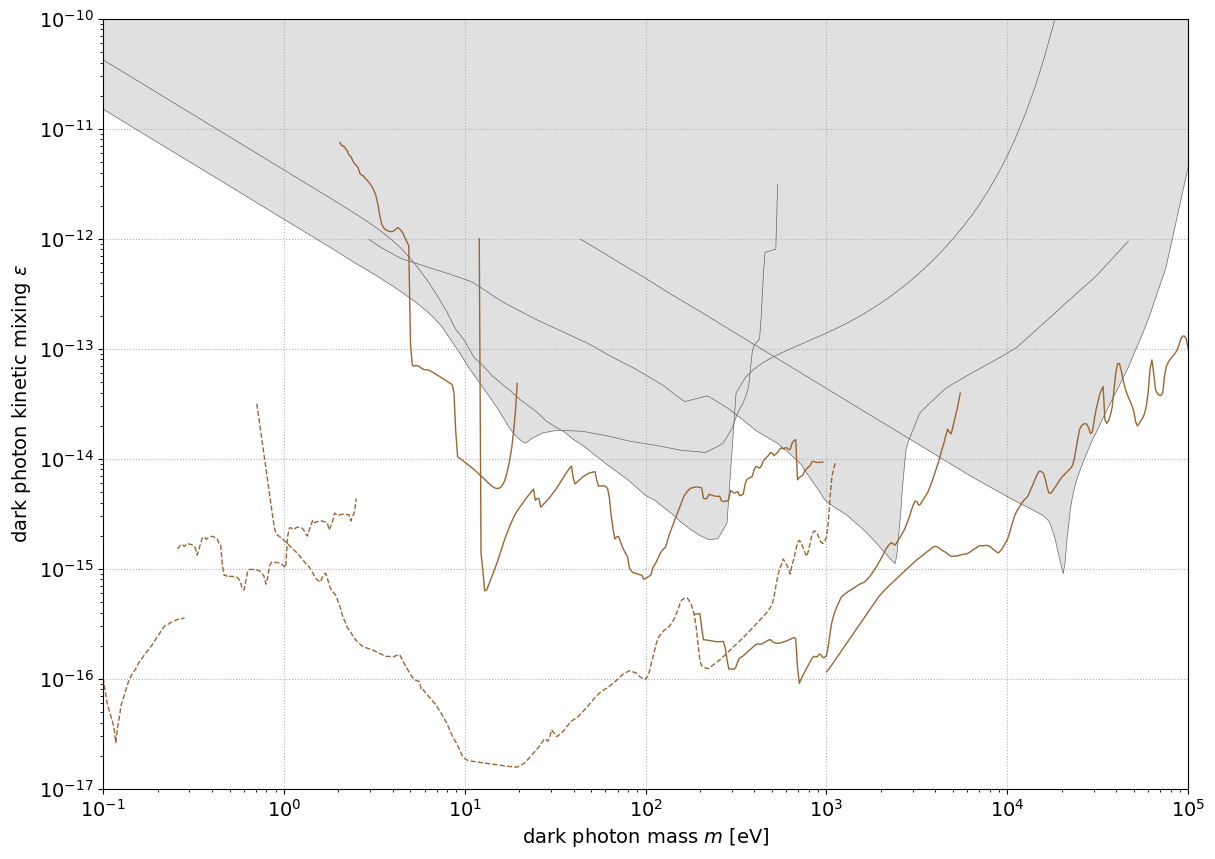

In [522]:
fig,ax=plt.subplots(1,1,figsize=(14,10))
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(1e-1,1e5); ax.set_ylim(1e-17,1e-10);
ax.grid(ls='dotted');
ax.set_xlabel(r'dark photon mass $m~[\mathrm{eV}]$'); ax.set_ylabel(r'dark photon kinetic mixing $\epsilon$');
vec_m = eV * np.logspace(-1,5,601)
ax.plot(vec_m/eV,epsilon_solar_cooling(vec_m),color=color_cooling,lw=lw_cooling);
ax.plot(vec_m/eV,epsilon_HB_cooling(vec_m),color=color_cooling,lw=lw_cooling);
ax.plot(vec_m[264:]/eV,epsilon_RG_cooling(vec_m[264:]),color=color_cooling,lw=lw_cooling);
ax.plot(vec_m/eV,epsilon_X1T_solar_unbound(vec_m),color=color_cooling,lw=lw_cooling);
ax.fill_between(vec_m/eV,np.nanmin([epsilon_solar_cooling(vec_m),epsilon_HB_cooling(vec_m),epsilon_RG_cooling(vec_m),epsilon_X1T_solar_unbound(vec_m)],axis=0),1,
                facecolor=facecolor_cooling,edgecolor=(0,0,0,0))

ax.plot(vec_m/eV,epsilon_Sensei_DM(vec_m),ls='solid',color=color_DM,lw=lw_DM);
ax.plot(vec_m[208:399]/eV,epsilon_X10_DM(vec_m[208:399]),ls='solid',color=color_DM,lw=lw_DM);
ax.plot(vec_m/eV,epsilon_X1T_S1_DM(vec_m),ls='solid',color=color_DM,lw=lw_DM);
ax.plot(vec_m/eV,epsilon_X1T_S1S2_DM(vec_m),ls='solid',color=color_DM,lw=lw_DM);
ax.plot(vec_m/eV,epsilon_SuperCDMS_DM(vec_m),ls='dashed',color=color_DM,lw=lw_DM);
ax.plot(vec_m/eV,epsilon_Stacks_DM(vec_m),ls='dashed',color=color_DM,lw=lw_DM);
ax.plot(vec_m/eV,epsilon_OptPhonon_DM(vec_m),ls='dashed',color=color_DM,lw=lw_DM);